In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, plot
import scipy as sp
from pathlib import Path
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/basic_results/trajectory_variance")

%matplotlib inline

# load

In [2]:
subjects = analysis.load_subjects()

In [3]:
subject_raw_traj_stacks = np.load("../subject_raw_trajectory_stacks.npy")
subject_traj_stacks = np.load("../subject_filtered_trajectory_stacks.npy")

subject_raw_traj_stacks.shape, subject_traj_stacks.shape

((46, 45, 12, 2, 2000), (46, 45, 12, 2, 2000))

In [4]:
def load_subject_indices(subject_idx):
    return np.load(f"../index_stacks/index_stack_{subject_idx}.npy")
subject_indices = load_subject_indices(0)
subject_indices.shape

(45, 12, 2000)

# rotate

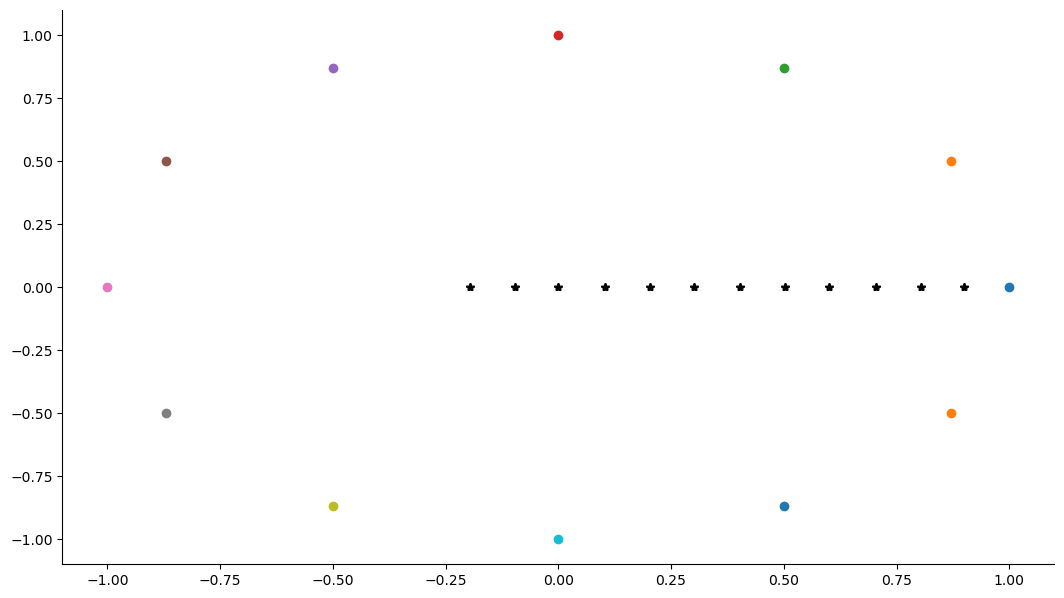

In [5]:
def make_2d_rotation_matrix(angle):
    return np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T

def rotation_matrix_from_target(target):
    # "undoes" the rotation by the target angle
    # assume [x, y]
    assert target.shape == (2,), target.shape
    # the "closest" angle between the two targets
    theta = np.arctan2(target[1],target[0])
    R = make_2d_rotation_matrix(theta)
    return R

def rotate(R, vec):
    return R @ vec

def rotate_trajectory(trajectory_samples, target_number):
    R = rotation_matrix_from_target(np.array(collection.compute_target_vec_from_number(target_number)))
    assert trajectory_samples.shape[0] > trajectory_samples.shape[1]
    assert trajectory_samples.shape[1] == 2
    return rotate(R, trajectory_samples.T)

# test
for target_number in range(1,13):
    vec = np.array([collection.compute_target_vec_from_number(target_number) for _ in range(3)])
    plt.plot(vec[0,0],vec[0,1],"o")
    r_vec = rotate_trajectory(vec, target_number)
    plt.plot(r_vec[0]-0.1*target_number,r_vec[1],"k*")


(46, 45, 12, 2, 2000)


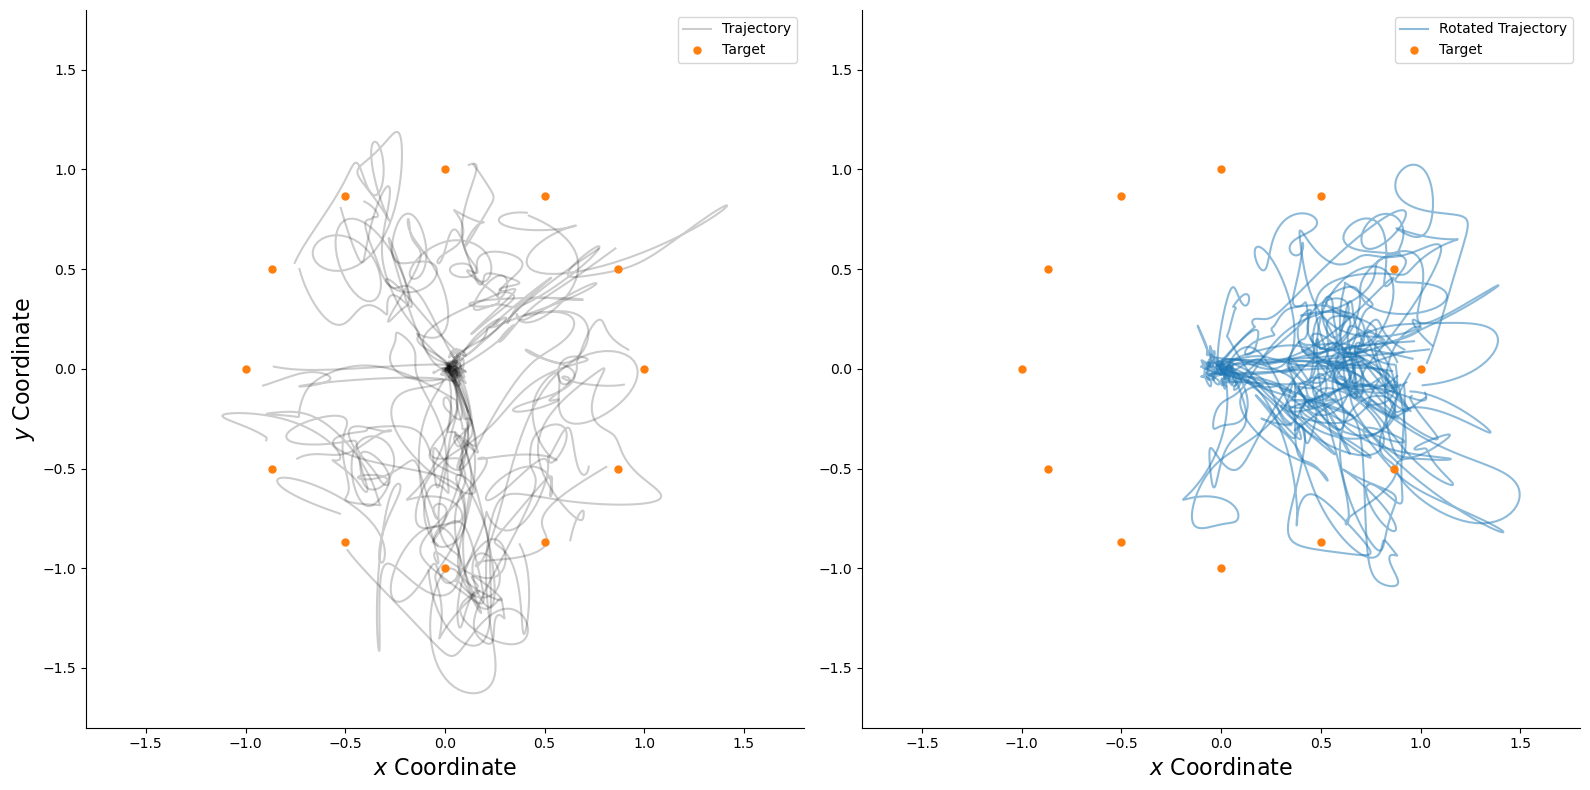

In [6]:
rotate_fig, axes = plt.subplots(1,2,figsize=(16,16))
handles1 = []
handles2 = []
print(subject_traj_stacks.shape)
for si in range(1,3):
    for ti in range(12):
        trajectory = subject_raw_traj_stacks[6,-si,ti].T
        r_vec = rotate_trajectory(trajectory, ti+1)
        h1, = axes[0].plot(trajectory[:,0],trajectory[:,1],"k-",alpha=0.2,label="Trajectory")
        h2, = axes[1].plot(r_vec[0],r_vec[1],"tab:blue",linestyle="-",marker="",alpha=0.5,label="Rotated Trajectory")
handles1.append(h1)
handles2.append(h2)
for ax in axes:
    h, = plot.plot_targets(ax,markerfacecolor="tab:orange",fillstyle="full",markeredgecolor="tab:orange",label="Target")
    ax.set_aspect("equal")
    ax.set_ylim([-1.8,1.8])
    ax.set_xlim([-1.8,1.8])
    ax.set_xlabel("$x$ Coordinate")
handles1.append(h)
handles2.append(h)
axes[0].legend(handles=handles1)
axes[1].legend(handles=handles2)
axes[0].set_ylabel("$y$ Coordinate")

rotate_fig.tight_layout()

In [7]:
plot.save_figure(rotate_fig,"rotated_trajectories",image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trajectory_variance/rotated_trajectories.pdf


# filter + rotate -- plot all targets over "chunks" of sessions

In [7]:
def chunk_indices():
    return [(i,j) for i,j in zip(range(0,45-9+1,9),range(9,46,9))]

def load_rotated_trajectories(subject_idx):
    rotated_trajectories = np.zeros_like(subject_traj_stacks[subject_idx])
    rotated_trajectories[:] = np.nan

    for session_idx in range(45):
        for target_idx in range(12):
            target_number = target_idx + 1
            # for each chunk
            trials = subject_traj_stacks[subject_idx,session_idx,target_idx]
            rotated_trajectories[session_idx,target_idx] = rotate_trajectory(trials.T,target_number)
    return rotated_trajectories


In [8]:
subject_idx = 1

rotated_trajectories = load_rotated_trajectories(subject_idx)
subject_indices = load_subject_indices(subject_idx)

# plot the chunks
for start_idx, end_idx in chunk_indices():
    # fig, axes = plt.subplots(1,1,figsize=(10,10))
    for target_idx in range(12):
        target_number = target_idx + 1
        # for each chunk
        chunk_trials = subject_traj_stacks[subject_idx,start_idx:end_idx,target_idx]
        rotated_chunk_trials = rotated_trajectories[start_idx:end_idx,target_idx]
        for i, (trial, r_trial) in enumerate(zip(chunk_trials,rotated_chunk_trials)):
            # plt.plot(trial[0],trial[1],"k",alpha=0.2)
            # plt.plot(r_trial[0],r_trial[1],"r",alpha=0.2)
            idx = analysis.remove_nan_rows(subject_indices[start_idx+i,target_idx].reshape(-1,1)).astype(int)
            # plt.plot(r_trial[0,idx],r_trial[1,idx],"ko",alpha=0.2)
    # plt.plot(0,0,"go")
    # plt.plot(1,0,"ro")

## variance in time

- load trajectories (maybe filtered? start with raw)
- rotate them and chunk them
- find the longest one, get it's length, interpolate all to this
- plot per target, per chunk

In [9]:
chunk_indices = analysis.make_chunk_indices()
subjects_to_plot = [6]
subject_rotated_trials = []

def interp_trajectory(x, traj):
    assert traj.shape[1] == 2
    assert traj.shape[0] > traj.shape[1]
    return np.column_stack([np.interp(x, np.arange(traj.shape[0]),traj[:,0]), np.interp(x, np.arange(traj.shape[0]),traj[:,1])])

maxlens = []
for subject_idx in range(len(subjects)):
    # these are raw!
    rotated_trajectories = load_rotated_trajectories(subject_idx)
    maxlen = 0
    trial_to_plot = np.empty(shape=(0,2))
    for trial in rotated_trajectories.transpose(0,1,3,2).reshape(-1,2000,2):
        l = analysis.remove_nan_rows(trial).shape[0]
        if l > maxlen:
            maxlen = l

    maxlens.append(maxlen)
    chunk_rotated_trials = np.zeros(shape=(5,9,12,maxlen,2))
    chunk_rotated_trials[:] = np.nan
    # chunk
    for i, (start_idx, end_idx) in enumerate(chunk_indices):
        # 9,12,2,2000
        rotated_chunk_trials = rotated_trajectories[start_idx:end_idx].transpose(0,1,3,2)
        # block in chunk 12 trials each
        for bi, block in enumerate(rotated_chunk_trials):
            # 12,2,2000
            for ti, trial in enumerate(block):
                no_nan_trial = analysis.remove_nan_rows(trial)
                if no_nan_trial.shape[0] <= 2:
                    chunk_rotated_trials[i,bi,ti,:,:] = np.nan
                else:
                    chunk_rotated_trials[i,bi,ti,:,:] = interp_trajectory(np.linspace(0,no_nan_trial.shape[0],maxlen,endpoint=True), no_nan_trial)
                    # chunk_rotated_trials[i,bi,ti,:no_nan_trial.shape[0],:] = no_nan_trial
    subject_rotated_trials.append(chunk_rotated_trials)

Text(0.5, -0.025, 'Block Group')

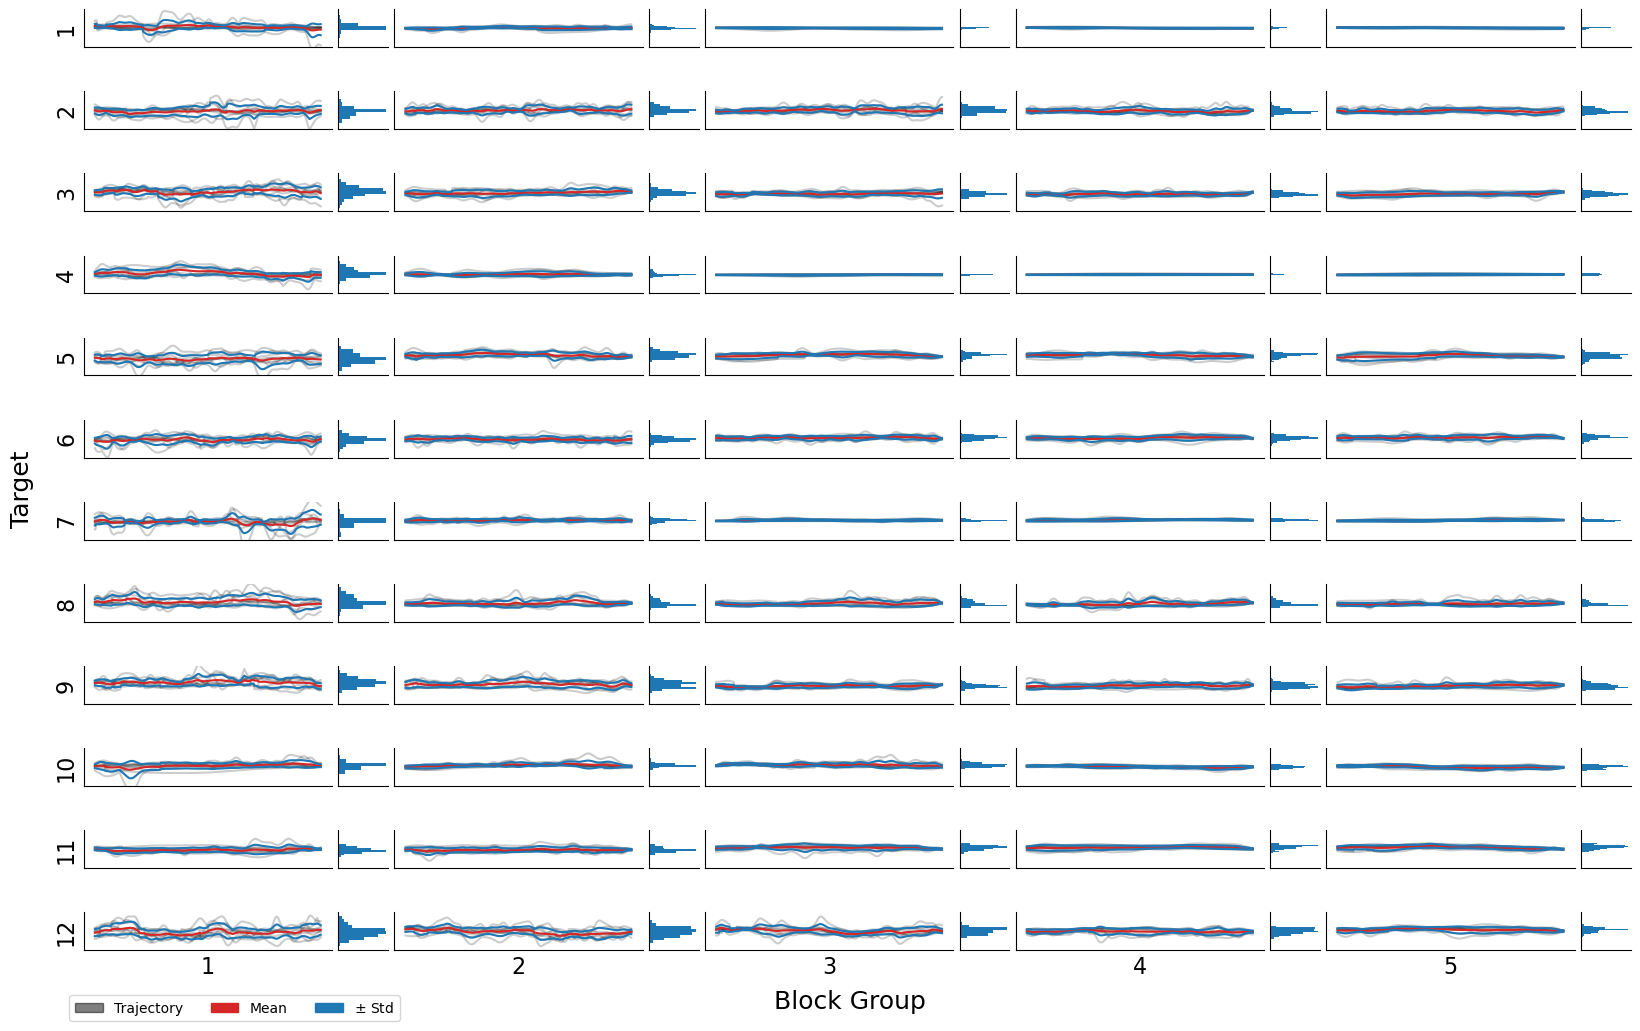

In [28]:
import matplotlib.patches as mpatches

wr = np.array([[5,1] for _ in range(5)]).flatten()
fig, axes = plt.subplots(12,10,figsize=(8*2,5*2),width_ratios=wr)
fig.tight_layout(w_pad=-2)

subject_idx = 32
x = np.linspace(0,1,maxlens[subject_idx])
for rotated_trials in subject_rotated_trials[subject_idx:subject_idx+1]:
    for ti in range(12):
        for chunk_i, ci in enumerate(range(0,10,2)):
            stack = rotated_trials[chunk_i,:,ti,:,1].T
            axes[ti,ci].plot(x,stack,"k",marker="",linestyle="-",alpha=0.2)
            axes[ti,ci+1].hist(stack.reshape(-1), orientation="horizontal")
            axes[ti,ci].plot(x,np.nanmean(stack,axis=1),"tab:red",marker="",linestyle="-")
            axes[ti,ci].plot(x,np.nanmean(stack,axis=1)+np.nanstd(stack,axis=1),"tab:blue",marker="",linestyle="-",zorder=100)
            axes[ti,ci].plot(x,np.nanmean(stack,axis=1)-np.nanstd(stack,axis=1),"tab:blue",marker="",linestyle="-",zorder=100)

for ax in axes.ravel():
    ax.set_ylim([-2.5,2.5])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])

for ti, i in enumerate(range(0,120,10)):
    ax = axes.ravel()[i]
    ax.set_ylabel(f"{ti+1}",fontsize=16)

for ti, i in enumerate(range(110,120,2)):
    ax = axes.ravel()[i]
    ax.set_xlabel(f"{ti+1}",fontsize=16)

# axes[-1,0].set_xticks(np.linspace(0,1,5,endpoint=True))
# axes[-1,0].set_xticklabels(np.linspace(0,1,5,endpoint=True))
# axes[-1,0].set_yticks([-2.5,2.5])
# axes[-1,0].set_yticklabels([-2.5,2.5])
handles = [mpatches.Patch(color='k', label='Trajectory', alpha=0.5),mpatches.Patch(color='tab:red', label='Mean'),mpatches.Patch(color='tab:blue', label='$\pm$ Std')]
axes[-1,0].legend(handles=handles, bbox_to_anchor=(1.3, -1.0), ncols=3)

fig.supylabel("Target",fontsize=18,x=-0.025)
fig.supxlabel("Block Group",fontsize=18,y=-0.025)

# fig, axes = plt.subplots(12,5,figsize=(15*3,5*3))

# for rotated_trials in subject_rotated_trials[9:10]:
#     for ti in range(12):
#         for ci in range(5):
#             stack = rotated_trials[ci,:,ti,:,1].T
#             axes[ti,ci].plot(stack,"k",marker="",linestyle="-",alpha=0.2)
#             axes[ti,ci].plot(np.nanmean(stack,axis=1),"tab:red",marker="",linestyle="-")
#             axes[ti,ci].plot(np.nanmean(stack,axis=1)+np.nanstd(stack,axis=1),"tab:red",marker="",linestyle="-",zorder=100)
#             axes[ti,ci].plot(np.nanmean(stack,axis=1)-np.nanstd(stack,axis=1),"tab:red",marker="",linestyle="-",zorder=100)

# for ax in axes.ravel():
#     ax.set_ylim([-2.5,2.5])
#     ax.set_xticklabels([])
#     ax.set_xticks([])

In [29]:
plot.save_figure(fig,"subject_example_trajectory_variance",image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trajectory_variance/subject_example_trajectory_variance.pdf


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


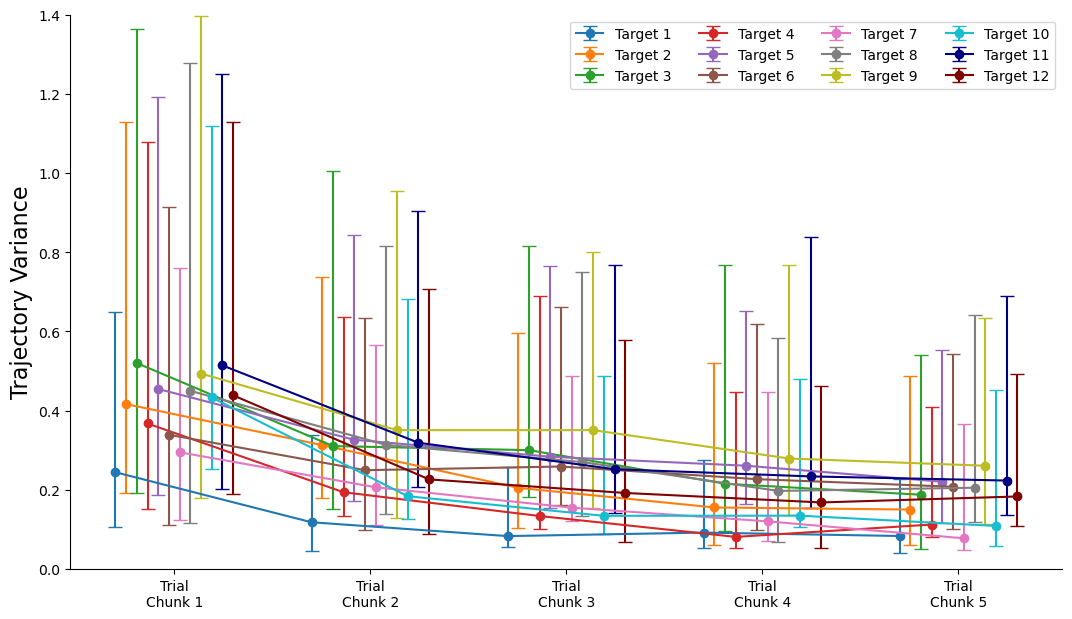

In [30]:
fig, ax = plt.subplots(1,1)
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan","navy","maroon"]
vars = np.zeros(shape=(46,12,5))
for si, rotated_trials in enumerate(subject_rotated_trials):
    for ti in range(12):
        for chunk_i, ci in enumerate(range(0,10,2)):
            stack = rotated_trials[chunk_i,:,ti,:,1].T
            vars[si,ti,chunk_i] = np.nanvar(stack)
handles = []
x = np.array([np.linspace(i-0.3,i+0.3,12) for i in range(1,6)])
for i, (xx, v) in enumerate(zip(x.T,vars.transpose(1,0,2))):
#    h = ax.errorbar(xx,y=np.mean(v,axis=0).T, yerr=2*v.std(axis=0).T/46, linestyle="-", marker="o", capsize=5, color=colors[i])
   h = ax.errorbar(xx,y=np.median(v,axis=0).T, yerr=np.stack([np.percentile(v,25,axis=0),np.percentile(v,75,axis=0)]), linestyle="-", marker="o", capsize=5, color=colors[i])
   handles.append(h) 

ax.set_xticks(np.arange(1,6))
ax.set_xticklabels([f"Trial\nChunk {i}" for i in range(1,6)])
ax.set_ylabel("Trajectory Variance")
ax.set_ylim([0,1.4])
ax.legend()
# handles, labels = ax.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=[f"Target {i+1}" for i in range(12)],ncols=4)

In [31]:
plot.save_figure(fig,"trajectory_variance_blocks",image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trajectory_variance/trajectory_variance_blocks.pdf


In [34]:
vars.mean(axis=1).T.shape

(5, 46)

Text(995.8377777777777, 0.5, '$p$ value')

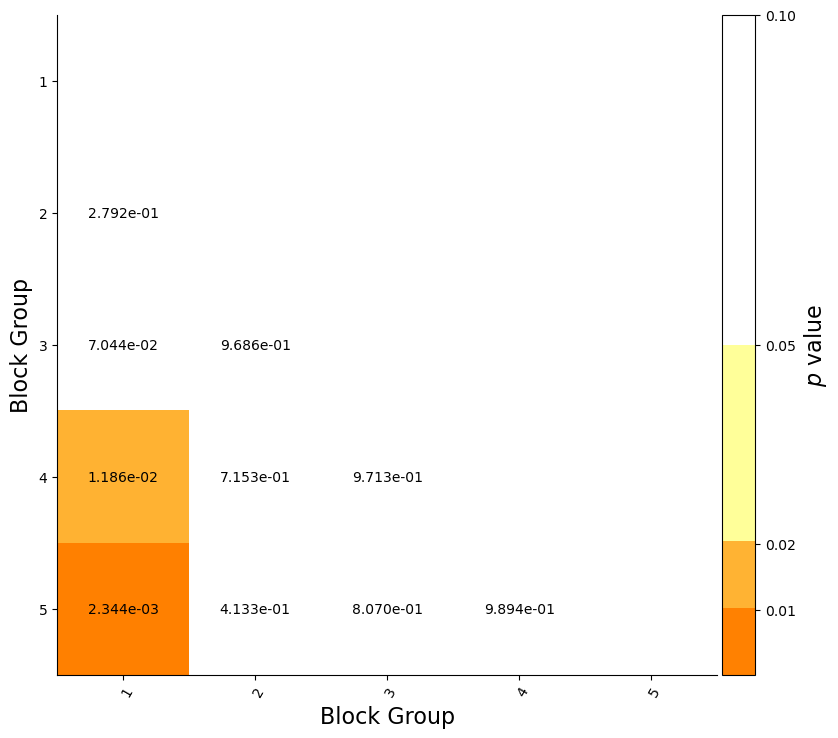

In [37]:
from scipy.stats import linregress, tukey_hsd
result = sp.stats.tukey_hsd(*vars.mean(axis=1).T)

pvalue_fig, axes = plot.annotated_heatmap(result.pvalue,list(range(1,6)),list(range(1,6)))
axes[0].set_xlabel("Block Group")
axes[0].set_ylabel("Block Group")
axes[1].set_ylabel("$p$ value")

In [39]:
plot.save_figure(pvalue_fig,"trajectory_variance_pvalues",image_path, format='png')

Figure saved to /Users/spencer/phd/phd/images/basic_results/trajectory_variance/trajectory_variance_pvalues.png


# old

## histograms

In [7]:
chunk_indices = list(zip(np.arange(45),np.arange(1,46)))

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:111

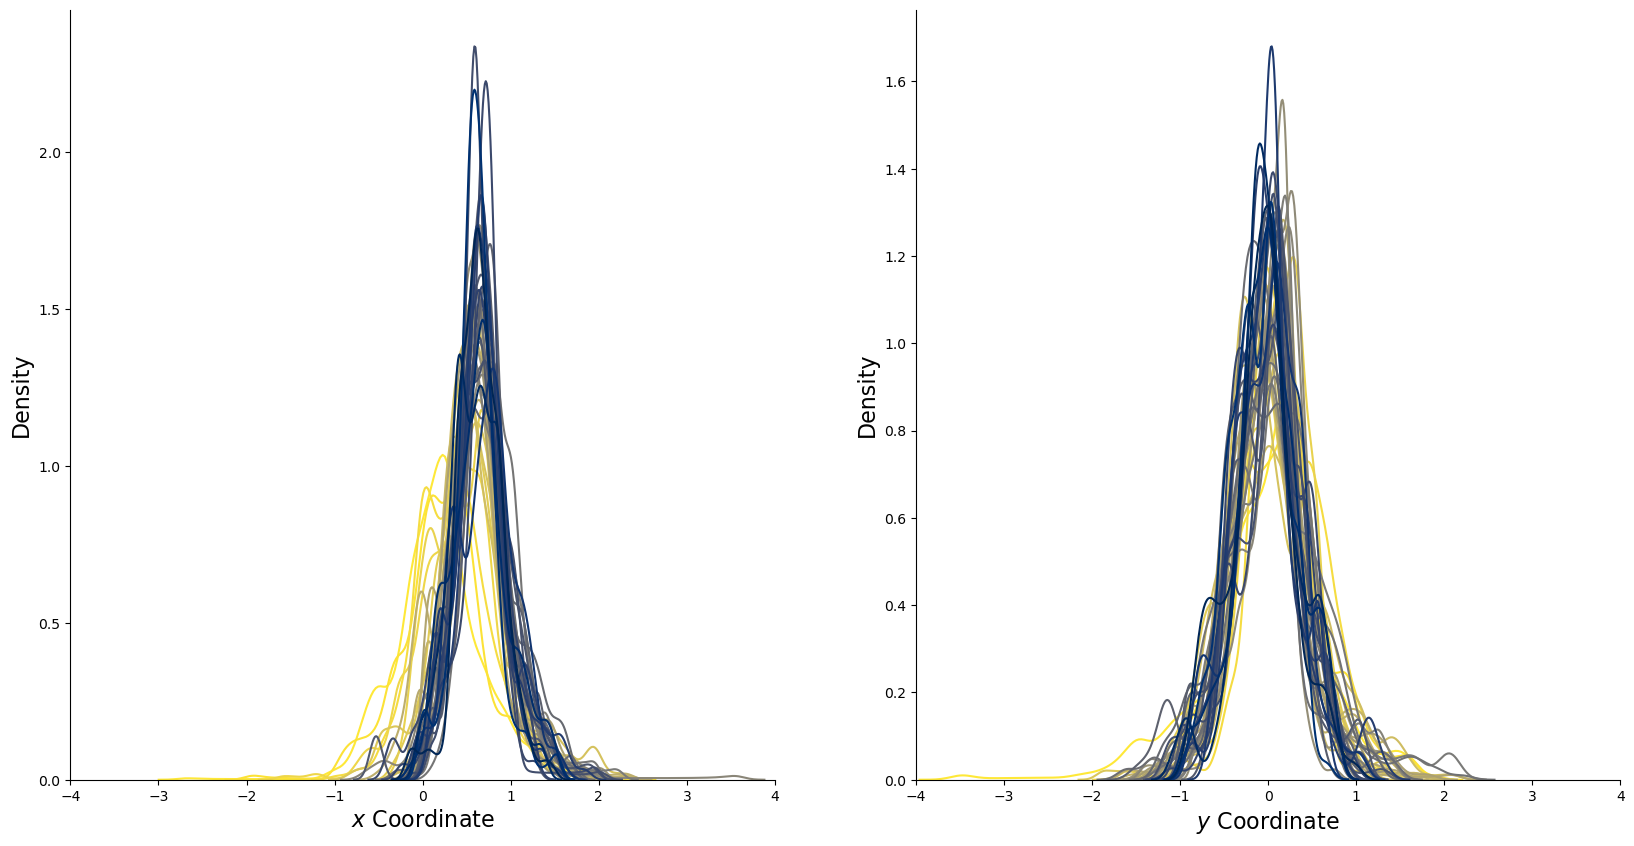

In [39]:
subject_vars = []
subjects_to_plot = [6]
for subject_idx in subjects_to_plot:
    fig, axes = plt.subplots(1,2,figsize=(20,10))
    for ax in axes:
        ax.set_xlim([-4,4])

    rotated_trajectories = load_rotated_trajectories(subject_idx)
    subject_indices = load_subject_indices(subject_idx)

    vars = []
    for i, (start_idx, end_idx) in enumerate(chunk_indices):
        
        rotated_chunk_trials = rotated_trajectories[start_idx:end_idx].transpose(0,1,3,2)
        chunk_trial_idxs = subject_indices[start_idx:end_idx]
        
        rotated_chunk_trials = rotated_chunk_trials.reshape(-1,2000,2)
        chunk_trial_idxs = chunk_trial_idxs.reshape(-1,2000)

        trial_to_plot = np.empty(shape=(0,2))
        for trial, trial_idx in zip(rotated_chunk_trials, chunk_trial_idxs):
            idxs = analysis.remove_nan_rows(trial_idx.reshape(-1,1)).reshape(-1).astype(int)
            trial_to_plot = np.append(trial_to_plot,trial[idxs,:],axis=0)
        trial_to_plot = analysis.remove_nan_rows(trial_to_plot)
        vars.append(np.var(trial_to_plot,axis=0))

        sns.kdeplot(trial_to_plot[:,0],color=colormaps["cividis"](1 - i/len(chunk_indices)),ax=axes[0],linestyle="-",marker="")
        sns.kdeplot(trial_to_plot[:,1],color=colormaps["cividis"](1 - i/len(chunk_indices)),ax=axes[1],linestyle="-",marker="")
    subject_vars.append(vars)
    axes[0].set_xlabel("$x$ Coordinate")
    axes[1].set_xlabel("$y$ Coordinate")

In [9]:
subject_vars = []
subjects_to_plot = [6,29,35,9]
for subject_idx in range(46):

    rotated_trajectories = load_rotated_trajectories(subject_idx)
    subject_indices = load_subject_indices(subject_idx)

    vars = []
    for i, (start_idx, end_idx) in enumerate(chunk_indices):
        
        rotated_chunk_trials = rotated_trajectories[start_idx:end_idx].transpose(0,1,3,2)
        chunk_trial_idxs = subject_indices[start_idx:end_idx]
        
        rotated_chunk_trials = rotated_chunk_trials.reshape(-1,2000,2)
        chunk_trial_idxs = chunk_trial_idxs.reshape(-1,2000)

        trial_to_plot = np.empty(shape=(0,2))
        for trial, trial_idx in zip(rotated_chunk_trials, chunk_trial_idxs):
            idxs = analysis.remove_nan_rows(trial_idx.reshape(-1,1)).reshape(-1).astype(int)
            trial_to_plot = np.append(trial_to_plot,trial[idxs,:],axis=0)
        trial_to_plot = analysis.remove_nan_rows(trial_to_plot)
        vars.append(np.var(trial_to_plot,axis=0))
    subject_vars.append(vars)

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [10]:
np.array(subject_vars).shape

(46, 45, 2)

In [11]:
best_subject_idxs = np.array([0,6,29,35])

Text(0, 0.5, '$\\log$(Trajectory Variance $y$)')

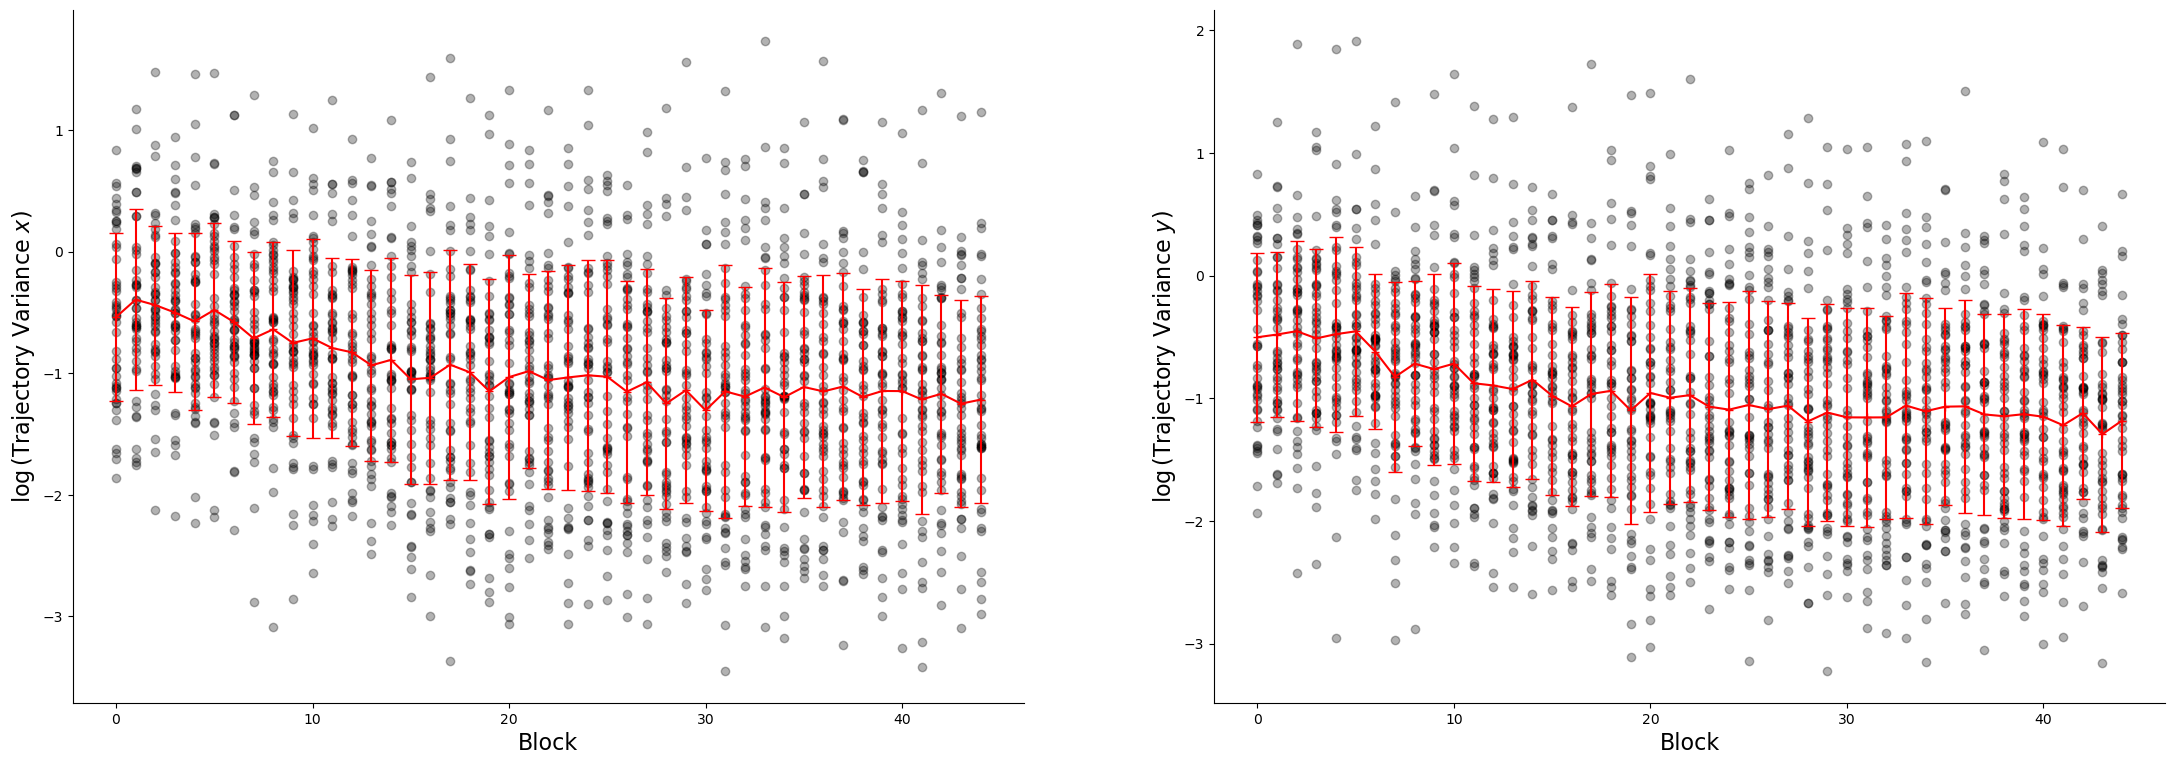

In [31]:
trajectory_variance_fig, axes = plt.subplots(1,2,figsize=(27,9))
fig.tight_layout()

ns = []
x_fit_results = []
for v in np.array(subject_vars)[:,:,0]:
    # diff = v - np.min(v)
    # n = diff / np.max(diff)
    # ns.append(n)
    # plt.plot(diff / np.max(diff),"ko")
    axes[0].plot(np.log(v),"ko",alpha=0.3)
    x_fit_results += [analysis.linear_fit(np.arange(45), np.log(v))]
axes[0].errorbar(x=np.arange(45),y=np.nanmean(np.log(np.array(subject_vars)[:,:,0]),axis=0),yerr=np.nanstd(np.log(np.array(subject_vars)[:,:,0]),axis=0),color="r",capsize=5,linestyle="-")
axes[0].set_xlabel("Block")
axes[0].set_ylabel("$\log$(Trajectory Variance $x$)")


ns = []
y_fit_results = []
for v in np.array(subject_vars)[:,:,1]:
    # diff = v - np.min(v)
    # n = diff / np.max(diff)
    # ns.append(n)
    # plt.plot(diff / np.max(diff),"ko")
    axes[1].plot(np.log(v),"ko",alpha=0.3)
    y_fit_results += [analysis.linear_fit(np.arange(45), np.log(v))]
# axes[1].plot(np.nanmean(ns,axis=0),"r")
axes[1].errorbar(x=np.arange(45),y=np.nanmean(np.log(np.array(subject_vars)[:,:,1]),axis=0),yerr=np.nanstd(np.log(np.array(subject_vars)[:,:,1]),axis=0),color="r",capsize=5,linestyle="-")
axes[1].set_xlabel("Block")
axes[1].set_ylabel("$\log$(Trajectory Variance $y$)")

In [32]:
plot.save_figure(trajectory_variance_fig,"trajectory_variance_over_blocks",image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trajectory_variance/trajectory_variance_over_blocks.pdf


In [13]:
mean_rewards = np.load("../subject_rewards.npy")

31
30


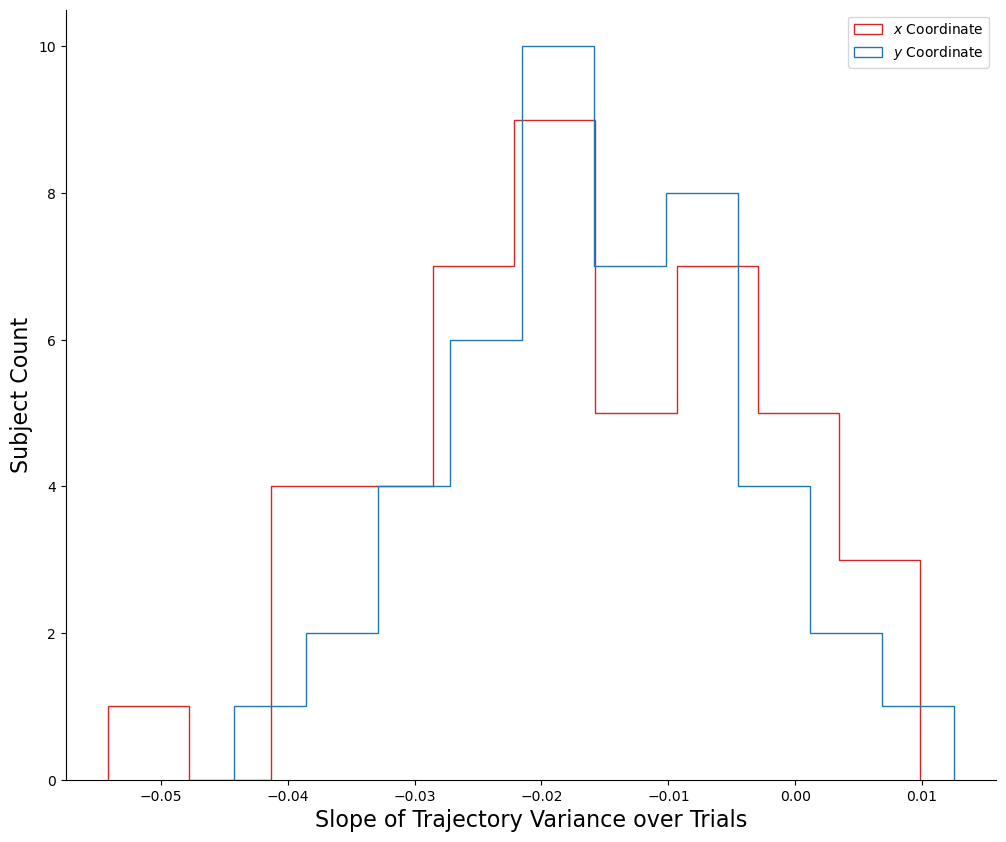

In [29]:
# plt.hist([fr.rvalue**2 for fr in x_fit_results],alpha=0.3)
# plt.hist([fr.rvalue**2 for fr in y_fit_results],alpha=0.3)

print(np.where(np.array([fr.pvalue for fr in x_fit_results])<0.05)[0].shape[0])
print(np.where(np.array([fr.pvalue for fr in y_fit_results])<0.05)[0].shape[0])

# plt.figure()
# plt.plot([fr.rvalue**2 for fr in x_fit_results], [fr.pvalue for fr in x_fit_results],"o")
# plt.plot([fr.rvalue**2 for fr in y_fit_results], [fr.pvalue for fr in y_fit_results],"o")

# plt.figure()
# plt.hist([fr.pvalue for fr in x_fit_results],bins=45)
# plt.hist([fr.pvalue for fr in y_fit_results],bins=45)
# plt.plot([0.05,0.05],[0,1],"r-")

variance_slope_fig = plt.figure(figsize=(12,10))
plt.hist([fr.slope for fr in x_fit_results],color="tab:red",histtype="step",label="$x$ Coordinate")
plt.hist([fr.slope for fr in y_fit_results],color="tab:blue",histtype="step",label="$y$ Coordinate")
plt.xlabel("Slope of Trajectory Variance over Trials")
plt.ylabel("Subject Count")
plt.legend()

In [30]:
plot.save_figure(variance_slope_fig, "trajectory_variance_slope", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trajectory_variance/trajectory_variance_slope.pdf


1 NaNs
(45,)
1 NaNs
LinregressResult(slope=0.18433771762847573, intercept=0.03824271798753051, rvalue=0.26514443794663156, pvalue=0.07836572488811755, stderr=0.10222768006631833, intercept_stderr=0.11083237954237438)


Text(0, 0.5, 'Variance Fit $R^2$ Value')

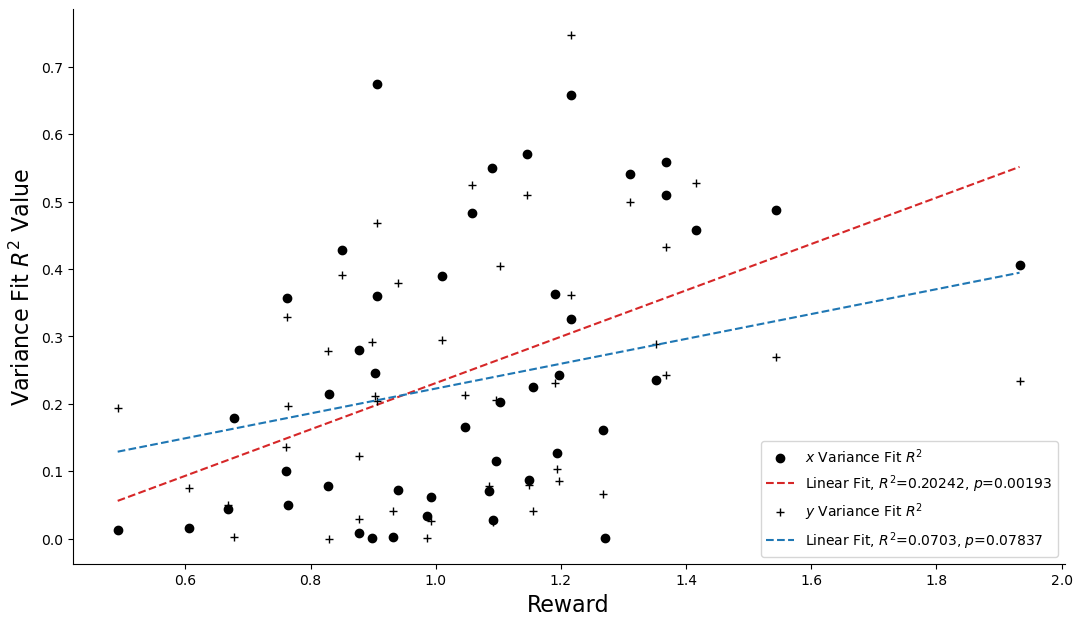

In [22]:
r2_fig = plt.figure()

x = mean_rewards.copy()
y = np.array([fr.rvalue**2 for fr in x_fit_results])

nan_idxs = np.where(np.isnan(y))[0]
print(len(nan_idxs), "NaNs")
y = np.delete(y, nan_idxs)
x = np.delete(x, nan_idxs)

print(y.shape)
res = analysis.linear_fit(x,y)
xl = analysis.linspace(x)
plt.plot(x, y,"ko",label="$x$ Variance Fit $R^2$") 
plot.plot_linear_fit(xl, res, plt.gca(),color="tab:red") 

x = mean_rewards.copy()
y = np.array([fr.rvalue**2 for fr in y_fit_results])

nan_idxs = np.where(np.isnan(y))[0]
print(len(nan_idxs), "NaNs")
y = np.delete(y, nan_idxs)
x = np.delete(x, nan_idxs)

res = analysis.linear_fit(x, y)
print(res)
xl = analysis.linspace(x)
plt.plot(x,y,"k+",label="$y$ Variance Fit $R^2$")
plot.plot_linear_fit(xl, res, plt.gca(),color="tab:blue")
plt.legend(loc=4)
plt.xlabel("Reward")
plt.ylabel("Variance Fit $R^2$ Value")

In [24]:
plot.save_figure(r2_fig, "trajectory_r_squared_fit", image_path)

Figure saved to /Users/spencer/phd/phd/images/basic_results/trajectory_variance/trajectory_r_squared_fit.pdf


# plot

### show trajectory variance decreasing over time for each target

/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

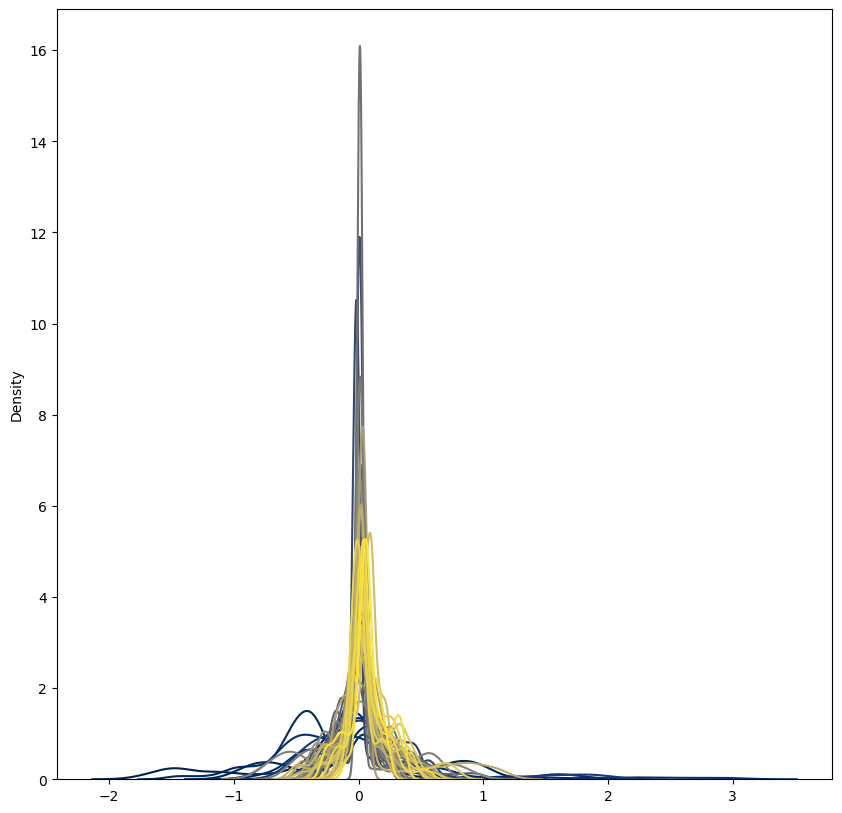

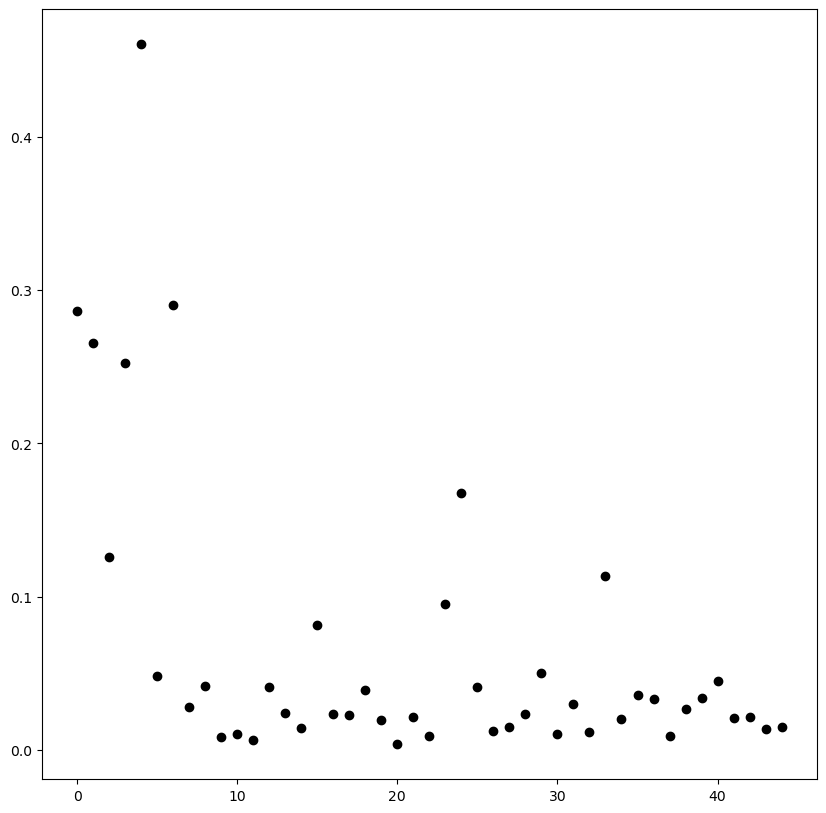

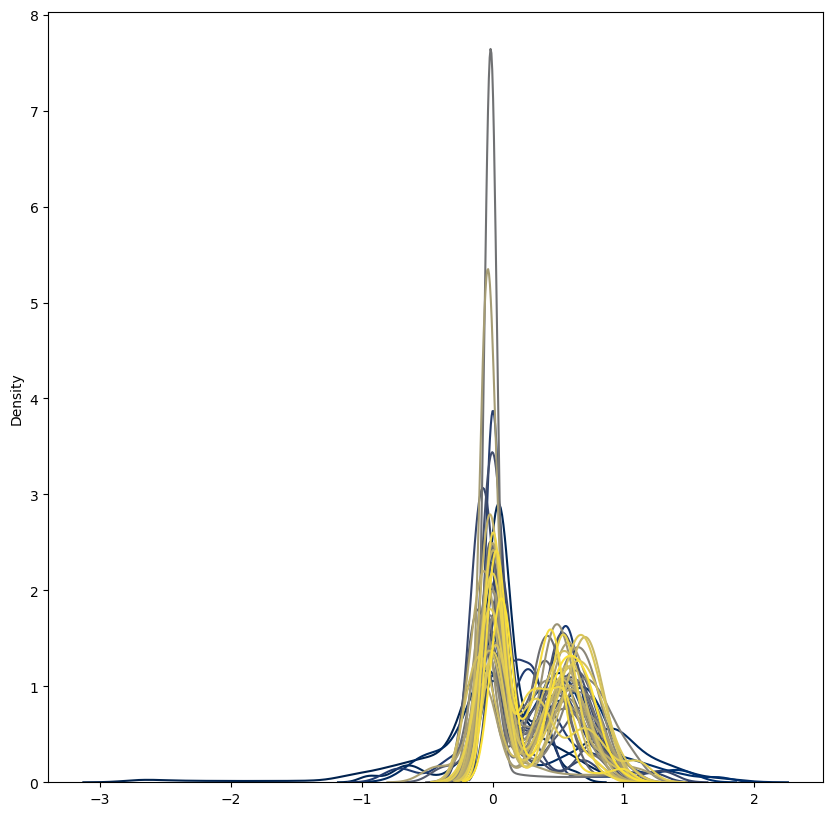

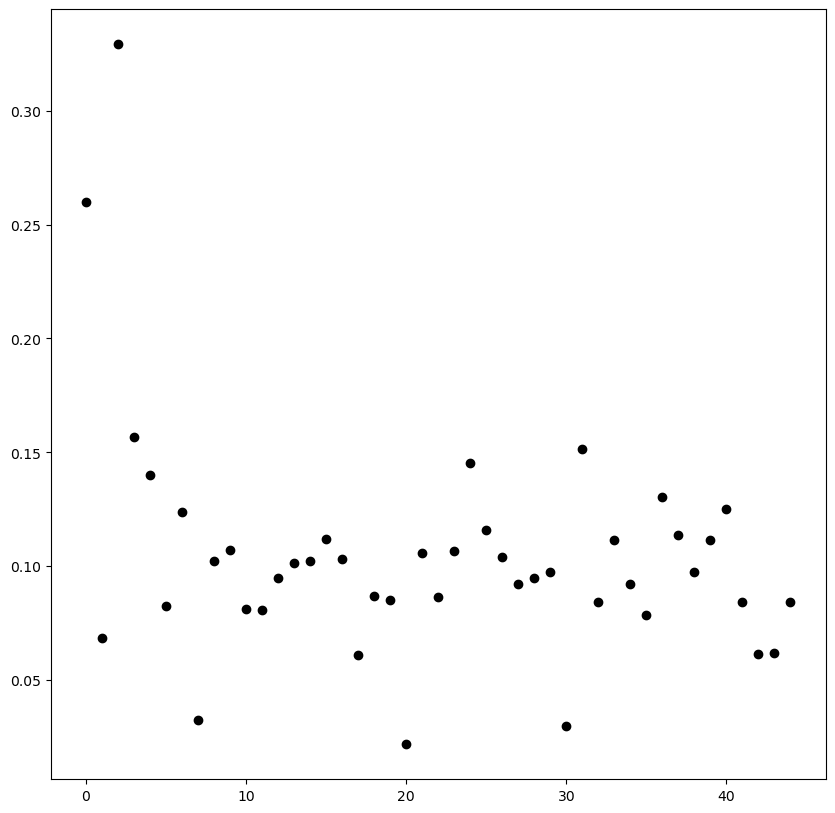

In [5]:
fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,0],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,0]),"ko")

fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,1],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,1]),"ko")

/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/spencer/miniconda3/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

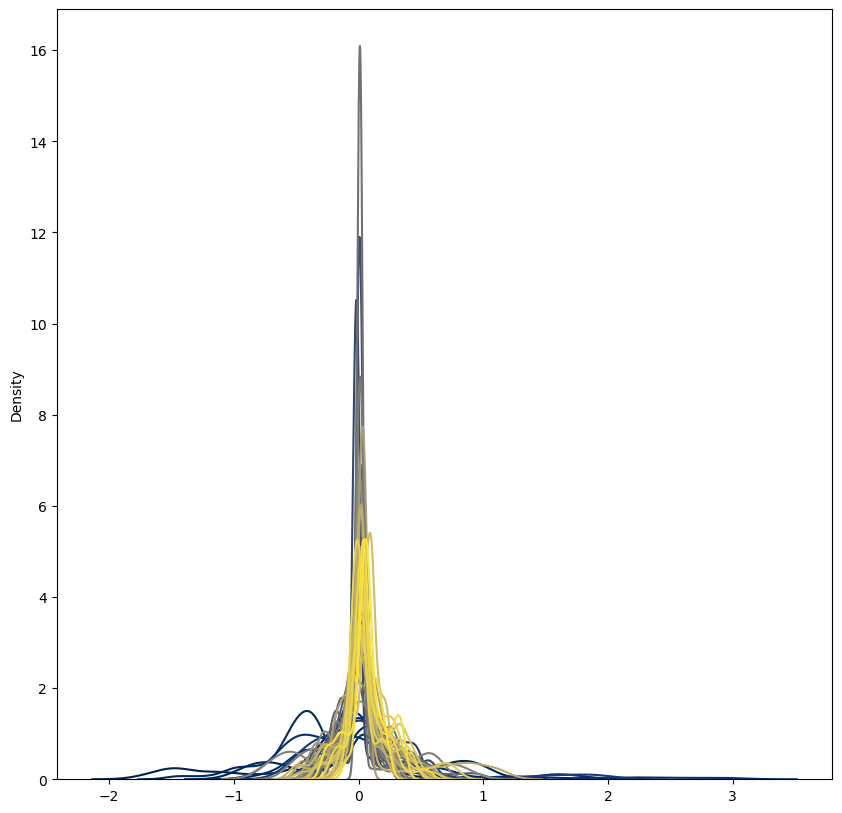

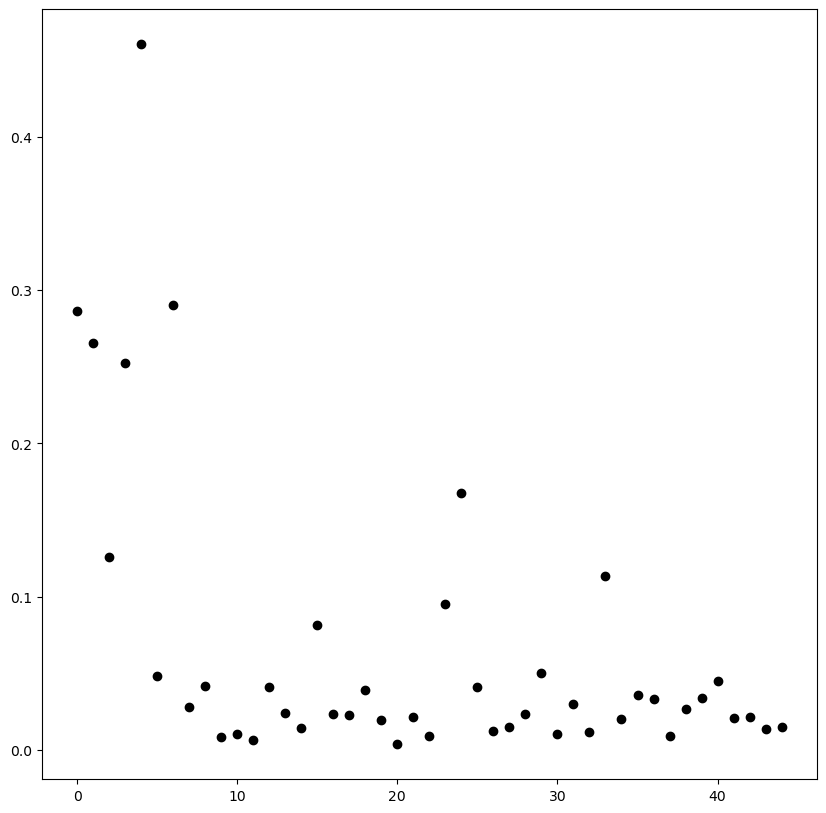

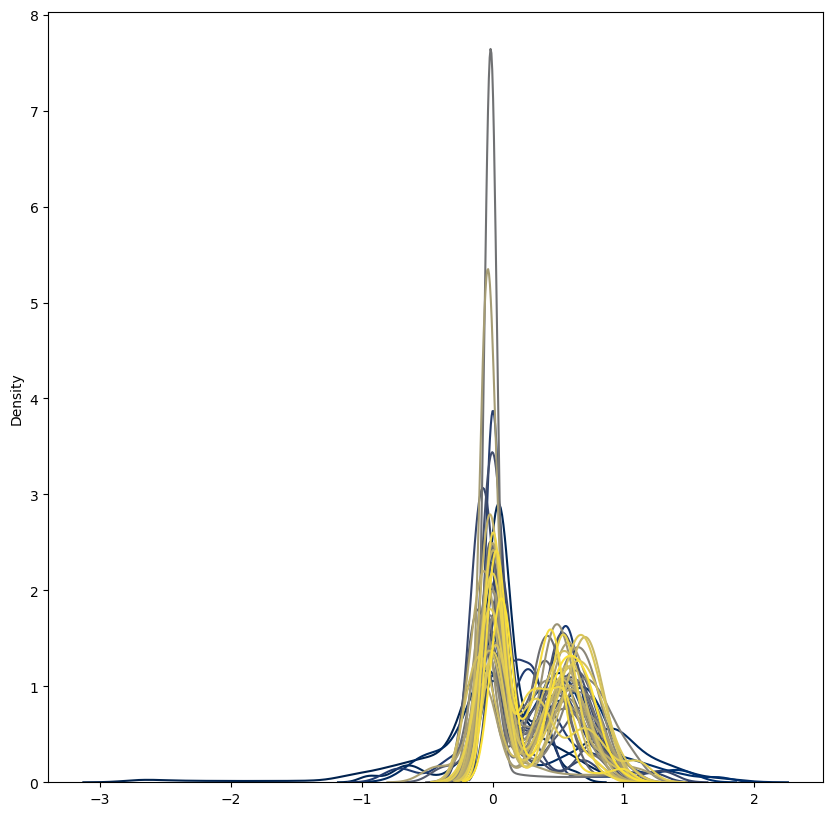

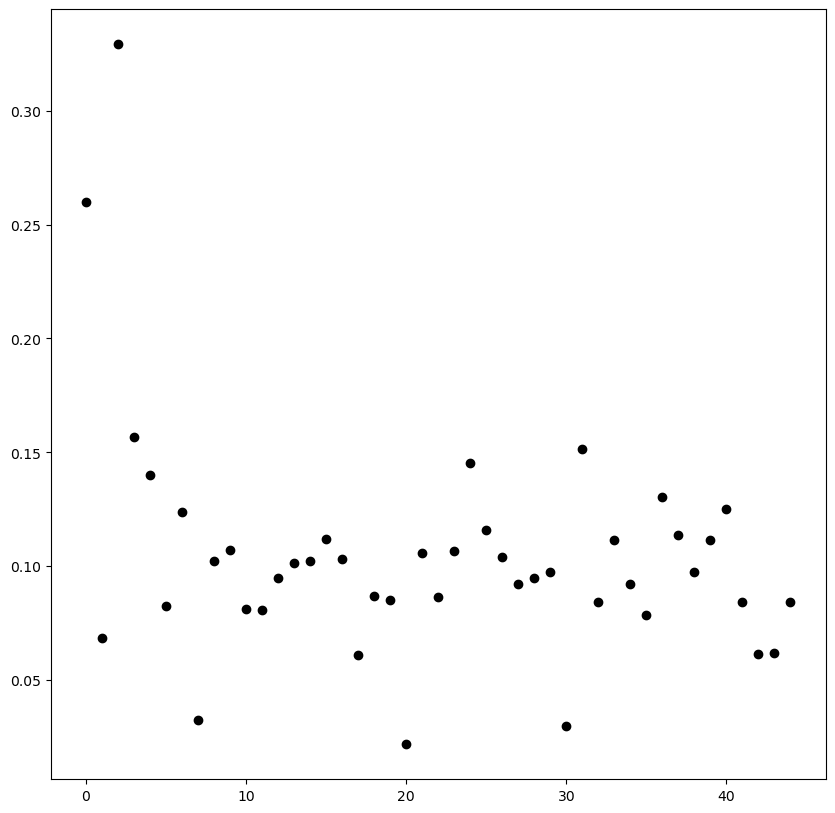

In [ ]:
fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,0],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,0]),"ko")

fig, hist_ax = plt.subplots(1,1,figsize=(10,10))
fig, var_ax = plt.subplots(1,1,figsize=(10,10))
for trial in range(45):
    sns.kdeplot(traj_stack[trial,1],color=colormaps["cividis"](trial/45),ax=hist_ax)
    var_ax.plot(trial,np.nanvar(traj_stack[trial,1]),"ko")

In [ ]:
c = collection.Collection("emg_olympics")
subject_number = 1
s = c.subjects[c.subject_names[subject_number]]
trials = []
for sesh in s.tasks["center_hold"].sorted_sessions():
    trials.extend(sesh.sorted_trials())
target_number = 12

first_hit_trial = None
last_hit_trial = None
for t in trials:
    if t.target_number == target_number and t.outcome == "Hit":
        first_hit_trial = t
# print(first_hit_trial.session_name, first_hit_trial.number)

for t in trials[::-1]:
    if t.target_number == target_number and t.outcome == "Hit":
        last_hit_trial = t
# print(last_hit_trial.session_name, last_hit_trial.number)

first_traj = first_hit_trial.get_trajectory()
last_traj = last_hit_trial.get_trajectory()
first_emg = first_hit_trial.get_filtered_emg()
last_emg = last_hit_trial.get_filtered_emg()
plt.plot(first_traj[:,-2],first_traj[:,-1])
plt.plot(last_traj[:,-2],last_traj[:,-1])
analysis.plot_targets(plt.gca())
plt.xlim([-2,2])
plt.ylim([-2,2])

plt.figure()
plt.plot(first_traj[:,-2])
plt.plot(last_traj[:,-2])

plt.figure()
plt.plot(first_traj[:,-1])
plt.plot(last_traj[:,-1])